In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as pltclr
import matplotlib.patches as patch
import skimage
import seaborn as sns

/tmp/ipykernel_483513/4231606411.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp
from utils.data67_processing import CellDataset, SubsetSampler

from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict
from utils.nb_utils import *


%load_ext autoreload
%autoreload 2
%matplotlib inline
import pprint

In [3]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Plot prediction on train cell

In [4]:
def normcorr(input1,input2):
    input1_0_mean = input1 - np.mean(input1)
    input2_0_mean = input2 - np.mean(input2)
    corr = np.mean(input1_0_mean * input2_0_mean)
    corr_norm = corr/np.std(input1_0_mean)/np.std(input2_0_mean)
    return corr_norm


In [5]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler
np.random.seed(1)
torch.random.manual_seed(1)


image_directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

model_name = 'protein1_datanormed_model_zyxin2pfak_aw_mse_corr_300ep'

modelinfo = torch.load('./tensorboard_logs/'+ model_name +'_0/model.pt',  map_location=torch.device(device))

dataset_kwargs = modelinfo['dataset_kwargs']

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])


prediction_result_folder = './zyxin2pfak_results/'

if not os.path.isdir(prediction_result_folder):          
    os.mkdir(prediction_result_folder)

model_prediction_result_folder = './zyxin2pfak_results/' + model_name + '/'

if not os.path.isdir(model_prediction_result_folder):          
    os.mkdir(model_prediction_result_folder)


plot_result_folder = model_prediction_result_folder +'plot'
tiff_result_folder = model_prediction_result_folder +'tiff'

if not os.path.isdir(plot_result_folder):          
    os.mkdir(plot_result_folder)

if not os.path.isdir(tiff_result_folder):          
    os.mkdir(tiff_result_folder)

crop_size = 1024
eval_dataset_kwargs = modelinfo['dataset_kwargs']
eval_dataset_kwargs['transform_kwargs']['crop_size'] = crop_size
eval_dataset_kwargs['transform_kwargs']['rotate'] = False
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)


pred_corr_df = pd.DataFrame(columns=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])

corr_matrix_zp = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)
corr_matrix_zn = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)
corr_matrix_np = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)        
flag_sc_z = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)        
flag_sc_p = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)    
flag_mask = np.full([600,round(crop_size/32),round(crop_size/32)], np.nan)    

z_p_corr= np.full([600,1], np.nan)
z_n_corr= np.full([600,1], np.nan)
p_n_corr= np.full([600,1], np.nan)
z_z_corr= np.full([600,1], np.nan)
p_p_corr= np.full([600,1], np.nan)



cell_index = -1
cell_train_test_flag = np.full([600,1], np.nan)
cell_ctrl_Y27_flag = np.full([600,1], np.nan)

for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(100):  
        cell_index = cell_index + 1

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()
        mask= sample['mask'].detach().cpu().numpy().squeeze()
        
        zyxin_seg =  sample['input_seg'].detach().cpu().numpy().squeeze()
        pax_seg =  sample['output_seg'].detach().cpu().numpy().squeeze() 

        from skimage.morphology import square, dilation
        dilate_mask = dilation(mask, square(64))>0

        zyxin_values = zyx[dilate_mask>0]
        pfak_values = pax[dilate_mask>0]
        nn_values = pred.squeeze()[dilate_mask>0]    

        for xi in range(0,round(crop_size/32)):
            for yi in range(0,round(crop_size/32)):
                z_patch = zyx[xi*32:xi*32+32,yi*32:yi*32+32]
                p_patch = pax[xi*32:xi*32+32,yi*32:yi*32+32]
                n_patch = pred[xi*32:xi*32+32,yi*32:yi*32+32]
                z_seg_patch = zyxin_seg[xi*32:xi*32+32,yi*32:yi*32+32]
                p_seg_patch = pax_seg[xi*32:xi*32+32,yi*32:yi*32+32]
                mask_patch = mask[xi*32:xi*32+32,yi*32:yi*32+32]                
                
                corr_matrix_zp[cell_index, xi,yi] = normcorr(z_patch[z_patch>-0.10],p_patch[p_patch>-0.10])
                corr_matrix_zn[cell_index, xi,yi] = normcorr(z_patch[z_patch>-0.10],n_patch[n_patch>-0.10])
                corr_matrix_np[cell_index, xi,yi] = normcorr(n_patch[n_patch>-0.10],p_patch[p_patch>-0.10])
                
                flag_sc_z[cell_index, xi,yi] = z_seg_patch.mean()
                flag_sc_p[cell_index, xi,yi] = p_seg_patch.mean()
                flag_mask[cell_index, xi,yi] = mask_patch.mean()
                    
        z_p_corr[cell_index]  = normcorr(zyxin_values,pfak_values)
        z_n_corr[cell_index]  = normcorr(zyxin_values,nn_values)
        p_n_corr[cell_index]  = normcorr(pfak_values,nn_values)
        z_z_corr[cell_index]  = normcorr(zyxin_values,zyxin_values)
        p_p_corr[cell_index]  = normcorr(pfak_values,pfak_values)
        
        train_test_flag= 'train'
        cell_train_test_flag[cell_index] = 1
            
        if cell == 'cell_3' or cell == 'cell_6' :
            train_test_flag= 'test'
            cell_train_test_flag[cell_index] = 0
            
        if cell == 'cell_1' or cell == 'cell_2'  or cell == 'cell_3':
            cell_ctrl_Y27_flag[cell_index] = 1
        else:
            cell_ctrl_Y27_flag[cell_index] = 0
            
            
        # s = pd.Series([cell, frame, train_test_flag,z_p_corr[cell_index] , z_n_corr[cell_index] , p_n_corr[cell_index]  ],
        #                 index=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])
        # pred_corr_df = pred_corr_df._append(s,ignore_index=True)

        # pred_corr_df.to_csv(os.path.join(model_prediction_result_folder,model_name+'z2p_prediction_300epochs_corr_gridplot.csv'))

        # fig,ax=plt.subplots(2,3,figsize=(8, 5*1), dpi=200)

        # ax[0,0].set_title('Zyxin', fontsize=8)
        # ax[0,0].imshow(zyx,  cmap='gray', vmax=1, vmin=0)
        # if cell == 'cell_3' or cell == 'cell_6' :
        #     ax[0,0].set_xlabel('Testing set: ' + cell)
        # else:
        #     ax[0,0].set_xlabel('Training set: ' + cell)
            
        # for yline in range(0,1024,32):
        #     ax[0,0].plot([0,1024],[yline,yline], linewidth=0.1)
        #     ax[0,0].plot([yline,yline],[0,1024], linewidth=0.1)   
        # ax[0,0].set_xlim(0,1024) 
        # ax[0,0].set_ylim(0,1024) 
        # ax[0,0].axis('off')
            
        # ax[0,1].set_title('pFAK-Exp', fontsize=8)
        # ax[0,1].imshow(pax, cmap='gray', vmax=1, vmin=0)
        # ax[0,1].set_xlabel('Frame '+ str(frame))
        # for yline in range(0,1024,32):
        #     ax[0,1].plot([0,1024],[yline,yline], linewidth=0.1)
        #     ax[0,1].plot([yline,yline],[0,1024], linewidth=0.1)   
        # ax[0,1].set_xlim(0,1024) 
        # ax[0,1].set_ylim(0,1024) 
        # ax[0,1].axis('off')

        # ax[0,2].set_title('pFAK-NN', fontsize=8)
        # ax[0,2].imshow(pred.squeeze()*dilate_mask,  cmap='gray', vmax=1, vmin=0)
        # ax[0,2].set_xlabel('zp'+ "%.2f" % (z_p_corr[cell_index] ) +',zn'+ "%.2f" % (z_n_corr[cell_index] ) +',pn'+ "%.2f" % (p_n_corr[cell_index] ))#+',zz'+ "%.2f" % (z_z_corr)+',pp'+ "%.2f" % (p_p_corr))
        # for yline in range(0,1024,32):
        #     ax[0,2].plot([0,1024],[yline,yline], linewidth=0.1)
        #     ax[0,2].plot([yline,yline],[0,1024], linewidth=0.1)   
        # ax[0,2].set_xlim(0,1024) 
        # ax[0,2].set_ylim(0,1024) 
        # ax[0,2].axis('off')


        # ax[1,0].set_title('Zyxin Seg', fontsize=8)
        # ax[1,0].imshow(zyxin_seg,  cmap='gray', vmax=1, vmin=0)
        # for yline in range(0,1024,32):
        #     ax[1,0].plot([0,1024],[yline,yline], linewidth=0.1)
        #     ax[1,0].plot([yline,yline],[0,1024], linewidth=0.1)   
        # ax[1,0].set_xlim(0,1024) 
        # ax[1,0].set_ylim(0,1024) 
        # ax[1,0].axis('off')

        # ax[1,1].set_title('pFAK Seg', fontsize=8)
        # ax[1,1].imshow(pax_seg,  cmap='gray', vmax=1, vmin=0)
        # for yline in range(0,1024,32):
        #     ax[1,1].plot([0,1024],[yline,yline], linewidth=0.1)
        #     ax[1,1].plot([yline,yline],[0,1024], linewidth=0.1)   
        # ax[1,1].set_xlim(0,1024) 
        # ax[1,1].set_ylim(0,1024) 
        # ax[1,1].axis('off')


        # ax[1,2].set_title('Mask', fontsize=8)
        # ax[1,2].imshow(mask,  cmap='gray', vmax=1, vmin=0)
        # for yline in range(0,1024,32):
        #     ax[1,2].plot([0,1024],[yline,yline], linewidth=0.1)
        #     ax[1,2].plot([yline,yline],[0,1024], linewidth=0.1)   
        # ax[1,2].set_xlim(0,1024) 
        # ax[1,2].set_ylim(0,1024) 
        # ax[1,2].axis('off')
        

        # tifffile.imsave(os.path.join(tiff_result_folder,cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        # for a in ax.flat:
        #     a.set_xticks([])
        #     a.set_yticks([])
                    
        # fig.savefig(os.path.join(plot_result_folder, 'grid_'+cell + '_frame'+str(frame)+'.png'))
        # plt.close(fig) 


{'crop_size': 1024, 'output_channels': 7, 'norm_output': {'rescale': 1, 'threshold': 0.0004}, 'rotate': False}


([<matplotlib.axis.XTick at 0x7f4b74b45fa0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

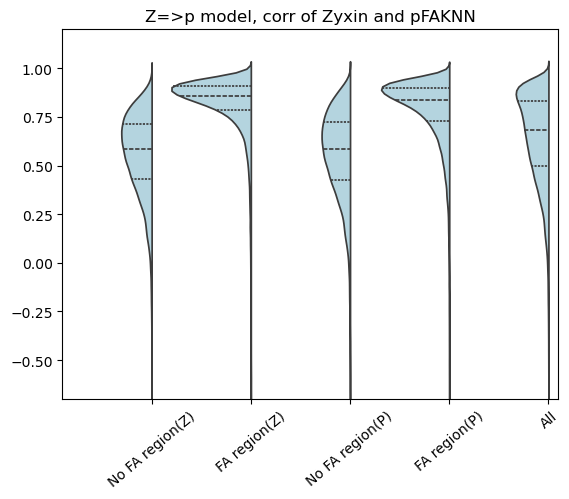

In [6]:
bscz = corr_matrix_zn[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zn[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zn[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zn[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zn[flag_mask>=0.99]

sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of Zyxin and pFAKNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)','No FA region(P)', 'FA region(P)', 'All'],rotation=40)


([<matplotlib.axis.XTick at 0x7f4b4c406ff0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

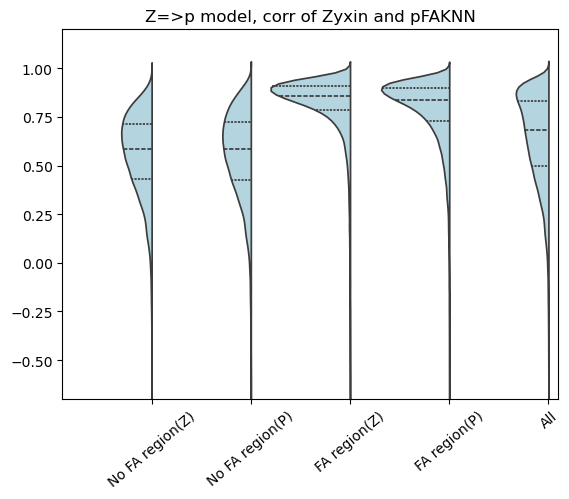

In [7]:
bscz = corr_matrix_zn[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zn[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zn[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zn[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zn[flag_mask>=0.99]

sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of Zyxin and pFAKNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)','FA region(Z)', 'FA region(P)', 'All'],rotation=40)



([<matplotlib.axis.XTick at 0x7f4b3bcadf10>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

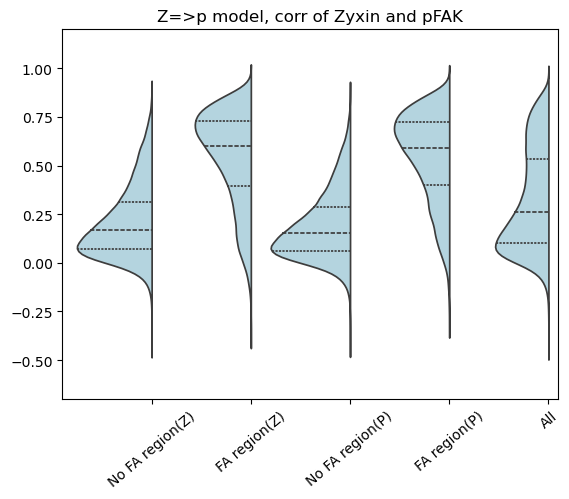

In [8]:
bscz = corr_matrix_zp[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zp[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zp[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zp[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zp[flag_mask>=0.99]

sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of Zyxin and pFAK')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)','No FA region(P)', 'FA region(P)', 'All'],rotation=40)


([<matplotlib.axis.XTick at 0x7f4b3bdafad0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

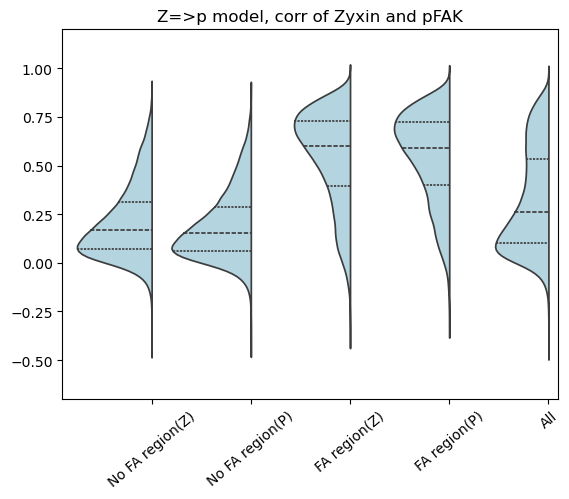

In [9]:
bscz = corr_matrix_zp[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zp[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zp[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zp[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zp[flag_mask>=0.99]

sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of Zyxin and pFAK')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)','FA region(Z)', 'FA region(P)', 'All'],rotation=40)


([<matplotlib.axis.XTick at 0x7f4ad15d41a0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

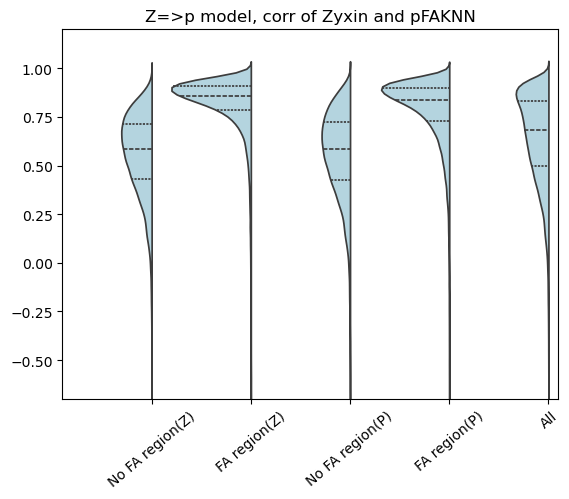

In [10]:
bscz = corr_matrix_zn[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zn[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zn[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zn[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zn[flag_mask>=0.99]

sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of Zyxin and pFAKNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)','No FA region(P)', 'FA region(P)', 'All'],rotation=40)

([<matplotlib.axis.XTick at 0x7f4ace5319d0>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'FA region(Z)'),
  Text(2.4, 0, 'No FA region(P)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

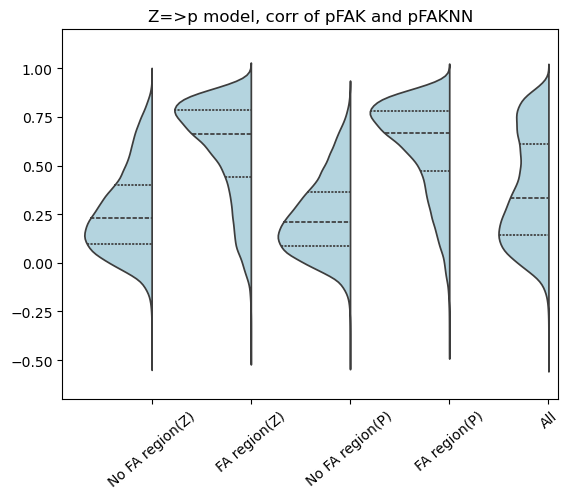

In [18]:
bscz = corr_matrix_np[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_np[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_np[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_np[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_np[flag_mask>=0.99]

sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of pFAK and pFAKNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'FA region(Z)','No FA region(P)', 'FA region(P)', 'All'],rotation=40)

([<matplotlib.axis.XTick at 0x7f4acc4a5d30>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

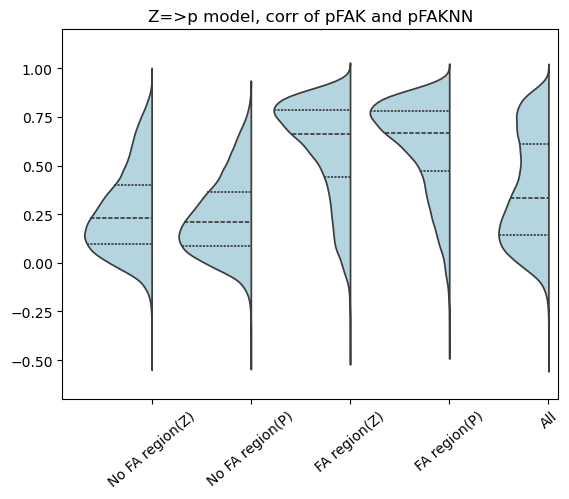

In [19]:
bscz = corr_matrix_np[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_np[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_np[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_np[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_np[flag_mask>=0.99]

sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of pFAK and pFAKNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)', 'FA region(Z)','FA region(P)', 'All'],rotation=40)

([<matplotlib.axis.XTick at 0x7f4ad15f2a50>,
 [Text(0.4, 0, 'No FA region(Z)'),
  Text(1.4, 0, 'No FA region(P)'),
  Text(2.4, 0, 'FA region(Z)'),
  Text(3.3999999999999995, 0, 'FA region(P)'),
  Text(4.3999999999999995, 0, 'All')])

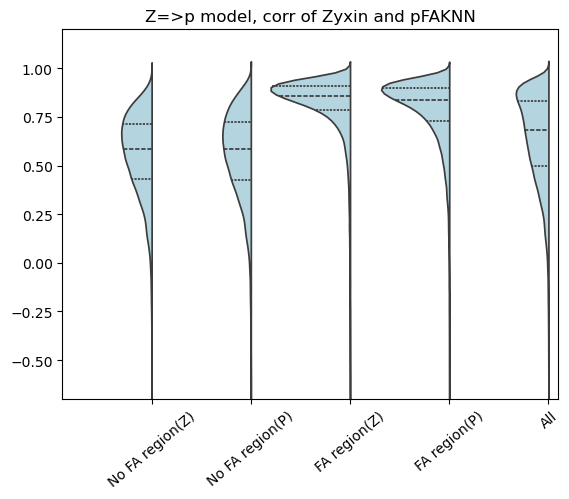

In [11]:
bscz = corr_matrix_zn[np.logical_and(flag_sc_z<=0.02,flag_mask>=0.99)]

scz = corr_matrix_zn[np.logical_and(flag_sc_z>0.02,flag_mask>=0.99)]

bscp = corr_matrix_zn[np.logical_and(flag_sc_p<=0.02,flag_mask>=0.99)]

scp = corr_matrix_zn[np.logical_and(flag_sc_p>0.02,flag_mask>=0.99)]

total_image_corr = corr_matrix_zn[flag_mask>=0.99]

sns.violinplot([bscz,bscp,scz,scp,total_image_corr],split=True, inner="quart",color='lightblue')
plt.xlim(-0.5,4.5)
plt.ylim(-0.7,1.2)

plt.title('Z=>p model, corr of Zyxin and pFAKNN')

plt.xticks(np.arange(0.4,5.4), ['No FA region(Z)', 'No FA region(P)', 'FA region(Z)','FA region(P)', 'All'],rotation=40)

<Axes: >

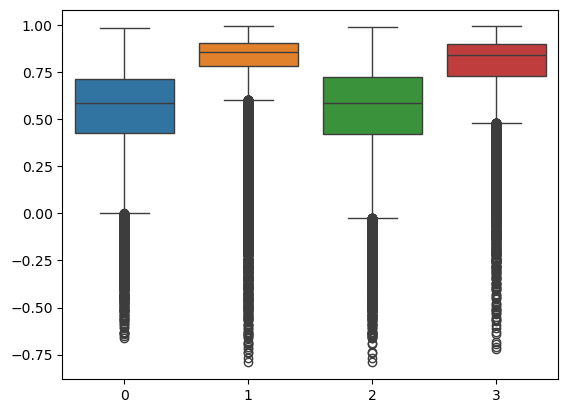

In [12]:
sns.boxplot([bscz,scz,bscp,scp])

<Axes: >

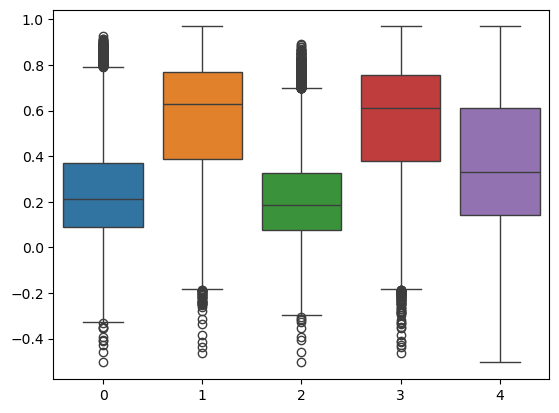

In [13]:
bscz = corr_matrix_np[np.logical_and(flag_sc_z<=0.01,flag_mask>=0.99)]

scz = corr_matrix_np[np.logical_and(flag_sc_z>0.01,flag_mask>=0.99)]

bscp = corr_matrix_np[np.logical_and(flag_sc_p<=0.01,flag_mask>=0.99)]

scp = corr_matrix_np[np.logical_and(flag_sc_p>0.01,flag_mask>=0.99)]

total_image_corr = corr_matrix_np[flag_mask>=0.99]

# sns.violinplot([bscz,scz,bscp,scp,total_image_corr],split=True, inner="quart")
sns.boxplot([bscz,scz,bscp,scp,total_image_corr])


<Axes: ylabel='Count'>

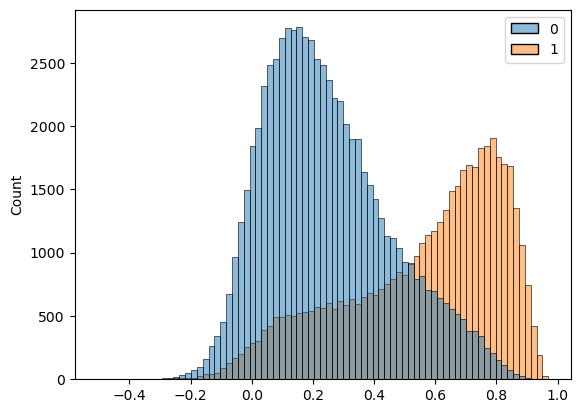

In [14]:




sns.histplot([bscz,scz])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4ace582180>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4ace582750>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4ace581f70>,
 'medians': [<matplotlib.lines.Line2D at 0x7f4ace582d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4ace583050>,
 'means': []}

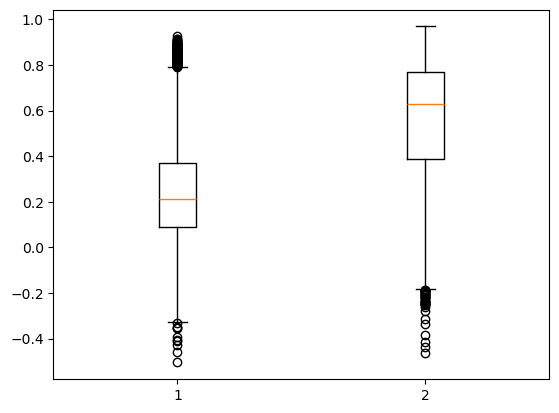

In [15]:
plt.boxplot([bscz,scz])

In [16]:
n_patch[n_patch>0]

array([0.00232309, 0.00974961, 0.0063052 , ..., 0.1121995 , 0.1264068 ,
       0.13139865], dtype=float32)

In [17]:
!ls


DataProcessing.ipynb
README.md
cellstress_venv.yml
example_dataset
load_trained_unet.ipynb
out
session_logs
tensorboard_logs
train_unet.ipynb
train_unet_1gpu4workers.ipynb.ipynb
train_unet_6to7_1gpu4workers.ipynb.ipynb
train_unet_6to7_loadfrome59.ipynb.ipynb
train_unet_7to6_1gpu4workers.ipynb.ipynb
train_unet_directrun.py
train_unet_multiple.ipynb
train_unet_multiple_2gpu4workers.ipynb.ipynb
train_unet_pax2zyxin.ipynb
train_unet_paxtozyxin_1g4w.ipynb
train_unet_ptoz_1g4w.ipynb.ipynb
train_unet_z2p_1gpu4workers.ipynb.ipynb
train_unet_zyxin2pFAK.ipynb
train_unet_zyxin2pax.ipynb
train_unet_zyxin2pfak_ch012.ipynb
train_unet_zyxin2pfak_ch67.ipynb
train_unet_zyxin2pfak_ch67_singleprotein.ipynb
train_unet_zyxin2pfak_ch76_singleprotein.ipynb
unet_pfak2zyxin_corr.ipynb
unet_zyxin2pfak_corr.ipynb
utils
zyxin2pfak_results
